# Elementary Recipe for Quantum Circuit Unoptimization

Code that implements the elementary recipe from "Quantum Circuit Unoptimization" ([arXiv:2311.03805](https://arxiv.org/pdf/2311.03805)).

## Preliminaries

In [1]:
import numpy as np
import random

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, random_unitary

First, we need a way of generating a random circuit consisting of two-qubit gates.

In [2]:
def random_two_qubit_circuit(num_qubits: int, depth: int) -> QuantumCircuit:
    """Generate a random quantum circuit with two-qubit gates.

    Args:
        num_qubits: The number of qubits in the circuit.
        depth: The number of layers (depth) of two-qubit gates.

    Returns:
        The generated random circuit.
    """
    qc = QuantumCircuit(num_qubits)

    # Map gate names to their corresponding methods
    gate_map = {
        "cx": qc.cx,
        "cz": qc.cz,
        "swap": qc.swap,
        "iswap": qc.iswap
    }

    for _ in range(depth):
        qubit1, qubit2 = random.sample(range(num_qubits), 2)
        gate = random.choice(list(gate_map.keys()))
        gate_map[gate](qubit1, qubit2)

    return qc

As an example, here is randomly generated 5-qubit and depth-10 circuit consisting of two-qubit gates 

In [3]:
num_qubits = 5
depth = 10
random_circuit = random_two_qubit_circuit(num_qubits, depth)

print(random_circuit)

                ┌───┐               
q_0: ──■────────┤ X ├────■──■─────■─
       │        └─┬─┘    │  │     │ 
q_1: ──┼──────────┼───■──┼──■──■──┼─
       │          │   │  │     │  │ 
q_2: ──┼──────X───┼───┼──┼──■──┼──┼─
     ┌─┴─┐    │   │   │  │  │  │  │ 
q_3: ┤ X ├─■──X───┼───■──┼──┼──┼──■─
     └───┘ │      │      │  │  │    
q_4: ──────■──────■──────■──■──■────
                                    


## Elementary recipe

The elementary recipe (ER) for quantum circuit unoptimization is given by Figure-1 in [arXiv:2311.03805](https://arxiv.org/pdf/2311.03805). The ER contains the following steps (applied in the following order):

1. Gate insertion
2. Gate swapping
3. Gate decomposition
4. Gate synthesis

### Gate insertion

In [8]:
def gate_insert(qc: QuantumCircuit, strategy='default'):
    """Insert a two-qubit gate A and its Hermitian conjugate A† between two gates B1 and B2.

    Args:
        qc: The input quantum circuit.
        strategy: The strategy used to select the pair of two-qubit gates.

    Returns:
        new_qc: The modified quantum circuit with A and A† inserted.
        B1_info: Information about gate B1 (index, qubits, gate).
    """
    # Collect all two-qubit gates with their indices and qubits
    two_qubit_gates = []
    for idx, instruction in enumerate(qc.data):
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        if len(qargs) == 2:
            qubit_indices = [qc.find_bit(qarg).index for qarg in qargs]
            two_qubit_gates.append({'index': idx, 'qubits': qubit_indices, 'gate': instr})

    # Select a pair of gates based on the specified strategy
    found_pair = False
    if strategy == 'default':
        # Find a pair of gates that share a common qubit
        for i in range(len(two_qubit_gates)):
            for j in range(i+1, len(two_qubit_gates)):
                qubits_i = set(two_qubit_gates[i]['qubits'])
                qubits_j = set(two_qubit_gates[j]['qubits'])
                common_qubits = qubits_i & qubits_j
                if len(common_qubits) == 1:
                    B1_idx = two_qubit_gates[i]['index']
                    B2_idx = two_qubit_gates[j]['index']
                    B1_qubits = two_qubit_gates[i]['qubits']
                    B2_qubits = two_qubit_gates[j]['qubits']
                    B1_gate = two_qubit_gates[i]['gate']
                    shared_qubit = list(common_qubits)[0]
                    found_pair = True
                    break
            if found_pair:
                break
    else:
        # Implement other strategies here
        pass

    if not found_pair:
        raise ValueError("No pair of two-qubit gates sharing a common qubit found.")

    # Generate a random two-qubit unitary A and its adjoint A†
    A = random_unitary(4)
    A_dag = A.adjoint()

    # Choose qubits for A and A† insertion
    all_qubits = set(range(qc.num_qubits))
    other_qubits = list(all_qubits - set(B1_qubits))
    if not other_qubits:
        raise ValueError("Not enough qubits to perform the operation.")
    third_qubit = other_qubits[0]
    shared_qubit = shared_qubit

    # Map indices back to qubits
    qubit_map = {qc.find_bit(q).index: q for q in qc.qubits}

    # Create a new circuit and insert A and A†
    new_qc = QuantumCircuit(qc.num_qubits)

    # Copy the gates up to and including B1
    for instruction in qc.data[:B1_idx+1]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Insert A on qubits [shared_qubit, third_qubit]
    qubits_for_A = [qubit_map[shared_qubit], qubit_map[third_qubit]]
    new_qc.unitary(A, qubits_for_A, label="A")

    # Insert A† on the same qubits
    new_qc.unitary(A_dag, qubits_for_A, label=r"$A^{\dagger}$")

    # Copy the remaining gates
    for instruction in qc.data[B1_idx+1:]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Prepare B1_info for gate_swap function
    B1_info = {
        'index': B1_idx,
        'qubits': B1_qubits,
        'gate': B1_gate,
        'shared_qubit': shared_qubit,
        'third_qubit': third_qubit,
        'A': A,
        'A_dag': A_dag
    }

    return new_qc, B1_info

                                                       
q_0: ─■──────────────────────────■─────■───────────────
      │ ┌────┐┌────────────────┐ │   ┌─┴─┐   ┌────────┐
q_1: ─┼─┤1   ├┤1               ├─┼───┤ X ├───┤1       ├
      │ │  A ││  $A^{\dagger}$ │ │ ┌─┴───┴──┐│  Iswap │
q_2: ─■─┤0   ├┤0               ├─■─┤0       ├┤0       ├
        └────┘└────────────────┘   │  Iswap │└────────┘
q_3: ──────────────────────────────┤1       ├──────────
                                   └────────┘          
{'index': 0, 'qubits': [2, 0], 'gate': Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), 'shared_qubit': 2, 'third_qubit': 1, 'A': Operator([[ 0.12974272-0.16652157j, -0.49347312-0.44200248j,
            0.19943261+0.49862718j,  0.03843168+0.47610509j],
          [ 0.66574541-0.05607j   , -0.24204974+0.42606116j,
            0.08947255+0.12836775j, -0.50382415-0.18761829j],
          [-0.47733652+0.05902384j, -0.43091516-0.06845355j,
           -0.00453582-0.40275915j, -0.634604

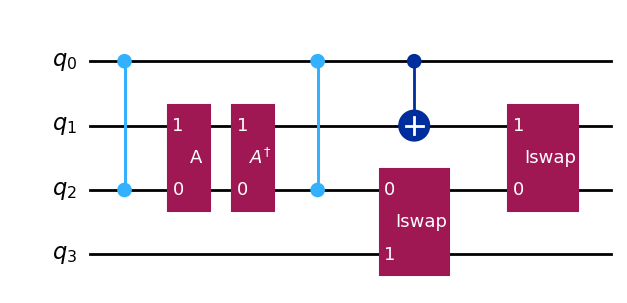

In [9]:
# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

# Perform gate insertion
inserted_qc, B1_info = gate_insert(qc)

print(inserted_qc)
print(B1_info)

inserted_qc.draw("mpl")

### Gate swapping

In [20]:
def gate_swap(qc: QuantumCircuit, B1_info):
    """Perform gate swapping by replacing A† with a three-qubit unitary.

    Args:
        qc: The quantum circuit returned by gate_insert.
        B1_info: Information about gate B1 and the inserted gates.

    Returns:
        new_qc: The modified quantum circuit after gate swapping.
    """
    B1_idx = B1_info['index']
    B1_qubits = B1_info['qubits']
    B1_gate = B1_info['gate']
    shared_qubit = B1_info['shared_qubit']
    third_qubit = B1_info['third_qubit']
    A_dag = B1_info['A_dag']

    # Map indices back to qubits
    qubit_map = {qc.find_bit(q).index: q for q in qc.qubits}
    q1 = qubit_map[B1_qubits[0]]
    q2 = qubit_map[B1_qubits[1]]
    q3 = qubit_map[third_qubit]

    # Get the unitary matrix of B1
    B1_operator = Operator(B1_gate)
    U_B1 = B1_operator.data

    # Compute the three-qubit unitary \widetilde{A^\dagger}
    I = np.eye(2)  # Identity for a single qubit

    # Compute B1 ⊗ I
    B1_tensor_I = np.kron(U_B1, I)

    # Compute (B1 ⊗ I)^\dagger
    B1_tensor_I_dag = B1_tensor_I.conj().T

    # Compute I ⊗ A^\dagger
    I_tensor_A_dag = np.kron(I, A_dag.data)

    # Compute \widetilde{A^\dagger}
    A_dag_tilde_data = B1_tensor_I_dag @ I_tensor_A_dag @ B1_tensor_I
    A_dag_tilde = Operator(A_dag_tilde_data)

    # Create a new circuit
    new_qc = QuantumCircuit(qc.num_qubits)

    # Copy the gates up to the insertion point of A†
    insertion_point = B1_idx + 2  # B1 and A have been inserted before A†
    for instruction in qc.data[:insertion_point]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Replace A† with \widetilde{A^\dagger} on qubits [q1, q2, q3]
    qubits_for_A_dag_tilde = [q1, q2, q3]
    new_qc.unitary(A_dag_tilde, qubits_for_A_dag_tilde, label="A_dag_tilde")

    # Copy the remaining gates, skipping the original A†
    for instruction in qc.data[insertion_point+1:]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    return new_qc

In [21]:
# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

# Perform gate insertion
inserted_qc, B1_info = gate_insert(qc)

print(inserted_qc)

# Perform gate swapping
final_qc = gate_swap(inserted_qc, B1_info)

# Print the final circuit
print(final_qc)

        ┌────┐┌─────┐                
q_0: ───┤1   ├┤1    ├─■──■─────■─────
        │  A ││  A† │ │  │   ┌─┴─┐   
q_1: ─■─┤0   ├┤0    ├─■──┼───┤ X ├───
      │ └────┘└─────┘    │ ┌─┴───┴──┐
q_2: ─■──────────────────■─┤1       ├
                           │  Iswap │
q_3: ──────────────────────┤0       ├
                           └────────┘
        ┌────┐┌──────────────┐                
q_0: ───┤1   ├┤2             ├─■──■─────■─────
        │  A ││              │ │  │   ┌─┴─┐   
q_1: ─■─┤0   ├┤0 A_dag_tilde ├─■──┼───┤ X ├───
      │ └────┘│              │    │ ┌─┴───┴──┐
q_2: ─■───────┤1             ├────■─┤1       ├
              └──────────────┘      │  Iswap │
q_3: ───────────────────────────────┤0       ├
                                    └────────┘


### Gate decomposition

In [ ]:
def gate_decompose():
    pass

### Gate synthesis

In [ ]:
def gate_synthesize():
    pass